# Iris classifier

In [2]:
from sklearn.datasets import load_iris
import matplotlib.pyplot as plt 
import seaborn as sns
import mlflow 

## Loading dataset

In [3]:
data = load_iris(as_frame=True)

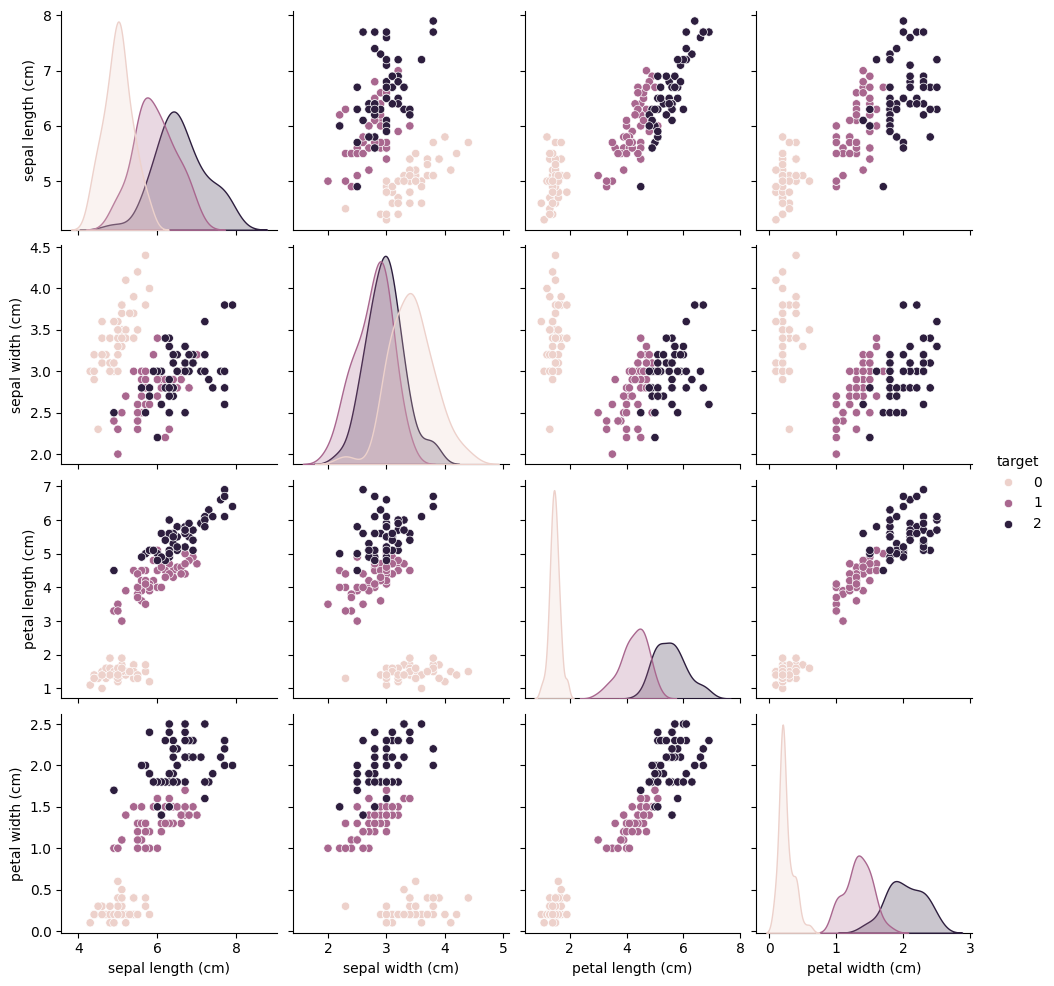

In [4]:

# Create a DataFrame with the features and target
df = data['frame']

# Plot the pairplot
sns.pairplot(df, hue='target')
pairplot_fig = plt.gcf()
plt.show()

# Training the classifier

In [6]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split
import pandas as pd 
from typing import Tuple

from sklearn.metrics import accuracy_score
from sklearn.metrics import classification_report
from sklearn.metrics import ConfusionMatrixDisplay


def get_train_test_data(df: pd.DataFrame, target: str)->Tuple[pd.DataFrame, pd.DataFrame, pd.Series, pd.Series]:
    """
    Get the train and test data from the DataFrame

    :param df: The DataFrame
    :param target: The target column
    :return: The train and test data
    """
    X = df.drop(target, axis=1)
    y = df[target]
    x_train, x_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)
    return x_train, x_test, y_train, y_test

In [7]:
x_train, x_test, y_train, y_test = get_train_test_data(df, 'target')

Accuracy: 1.0
{'0': {'precision': 1.0, 'recall': 1.0, 'f1-score': 1.0, 'support': 10.0}, '1': {'precision': 1.0, 'recall': 1.0, 'f1-score': 1.0, 'support': 9.0}, '2': {'precision': 1.0, 'recall': 1.0, 'f1-score': 1.0, 'support': 11.0}, 'accuracy': 1.0, 'macro avg': {'precision': 1.0, 'recall': 1.0, 'f1-score': 1.0, 'support': 30.0}, 'weighted avg': {'precision': 1.0, 'recall': 1.0, 'f1-score': 1.0, 'support': 30.0}}


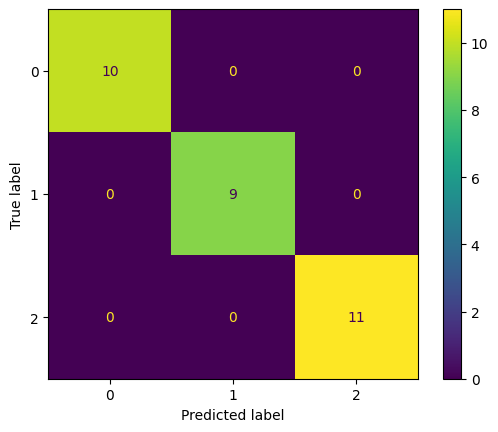

In [13]:
rfc = RandomForestClassifier()

# train the model
rfc.fit(x_train, y_train)

# predict the test data
y_pred = rfc.predict(x_test)

# calculate the accuracy
accuracy = accuracy_score(y_test, y_pred)
print(f'Accuracy: {accuracy}')

report = classification_report(y_test, y_pred, output_dict=True)
print(report)

cm = ConfusionMatrixDisplay.from_estimator(rfc, x_test, y_test)

## Log with mlflow

In [14]:
experiment_name = "iris_plants"
experiment_tags = {
    "mlflow.note.content":"Developing a model to classify iris flowers, this is a simple example",
    "model_type":"Classifier",
    "algorithm":"RandomForestClassifier",
    "framework":"sklearn"
}

try:
    experiment_id = mlflow.create_experiment(name=experiment_name, tags=experiment_tags)
    print(f'Experiment ID: {experiment_id}')
except Exception as e:
    print(f'Error creating experiment: {e}')
    
experiment = mlflow.set_experiment(experiment_name=experiment_name)   

Error creating experiment: Experiment 'iris_plants' already exists.


## Creating the model signature

In [15]:
from mlflow.models import ModelSignature
from mlflow.types.schema import Schema 
from mlflow.types.schema import ColSpec

input_schema = Schema([ColSpec(type="double", name = feature_name, required=True) for feature_name in x_train.columns])
output_schema = Schema([ColSpec(type="integer", name="target", required=True)])  

signature = ModelSignature(inputs=input_schema, outputs=output_schema)

## Tracking the dataset


In [16]:
# Create a DataFrame with the features and target
df = data['frame']

# Create an instance of a PandasDataset
dataset = mlflow.data.from_pandas(
    df,
    targets="target",
    name="iris_plants"
)

In [18]:
with mlflow.start_run(run_name="iris_classifier", description="Training an iris classifier") as run: 

    # log parameters
    mlflow.log_params(rfc.get_params())

    # log metrics
    mlflow.log_metric("accuracy", accuracy)

    # log the classification report
    mlflow.log_dict(report, artifact_file="classification_report.yaml")

    # log the confusion matrix
    mlflow.log_figure(cm.figure_, artifact_file="confusion_matrix.png")

    # log the pairplot
    mlflow.log_figure(pairplot_fig, artifact_file="pairplot.png")

    # log the dataset
    mlflow.log_input(dataset=dataset, context="training_data", tags={"source":"iris dataset"})

    # log the model
    mlflow.sklearn.log_model(rfc, "model", signature=signature, input_example=x_train.head(1))



## Retrieving the model for inference.

In [27]:
runs = mlflow.search_runs(experiment_names=[experiment_name])

run_id = runs["run_id"].loc[0]

model_uri = f"runs:/{run_id}/model"

predictions = mlflow.models.predict(model_uri, input_data=x_test, env_manager="local")

2025/01/27 20:56:04 INFO mlflow.models.python_api: It is highly recommended to use `uv` as the environment manager for predicting with MLflow models as its performance is significantly better than other environment managers. Run `pip install uv` to install uv. See https://docs.astral.sh/uv/getting-started/installation for other installation methods.


2025/01/27 20:56:04 INFO mlflow.models.flavor_backend_registry: Selected backend for flavor 'python_function'


{"predictions": [1, 0, 2, 1, 1, 0, 1, 2, 1, 1, 2, 0, 0, 0, 0, 1, 2, 1, 1, 2, 0, 2, 0, 2, 2, 2, 2, 2, 0, 0]}

Loading the model using the sklearn flavor

In [34]:
loaded_model = mlflow.sklearn.load_model(model_uri)
print(type(loaded_model))
predictions = loaded_model.predict(x_test)
print(predictions)

<class 'sklearn.ensemble._forest.RandomForestClassifier'>
[1 0 2 1 1 0 1 2 1 1 2 0 0 0 0 1 2 1 1 2 0 2 0 2 2 2 2 2 0 0]


Loading the model using the pyfunc flavor.

In [36]:
loaded_model_py = mlflow.pyfunc.load_model(model_uri)
print(type(loaded_model_py))
predictions = loaded_model_py.predict(x_test)
print(predictions)

<class 'mlflow.pyfunc.PyFuncModel'>
[1 0 2 1 1 0 1 2 1 1 2 0 0 0 0 1 2 1 1 2 0 2 0 2 2 2 2 2 0 0]


In [31]:
type(loaded_model_py)

mlflow.pyfunc.PyFuncModel